In [1]:
import os
import numpy as np
import pickle

import torch
import torch.nn as nn
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
class simple_bidirectional_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bidirectional):
        super(simple_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=bidirectional)
        if output_size != 0:
            self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_x, hidden):
        output, hidden = self.lstm(input_x, hidden)
        if self.output_size != 0:
            output = self.fc(output)
        return output, hidden
    
    def initHidden(self):
        if self.bidirectional:
            result = Variable(torch.zeros(2, 1, self.hidden_size))
        else:
            result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda()

In [3]:
class simple_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(simple_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        if output_size != 0:
            self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_x, hidden):
        output, hidden = self.lstm(input_x, hidden)
        if self.output_size != 0:
            output = self.fc(output)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
########## Load RGB Player Features and Dictionaries ############
player_feature_path = './consistent_players/player_feature_spatial'
player_corr_path = './consistent_players/corr'
game_ids = ['1365-1', '1382-1', '1382-2', '1382-3', '1395-1', '1395-2', '1395-3', '1403-2', '1403-3', '1497-2']
#game_ids = ['1365-1', '1382-1']
#game_ids = ['1365-1']

In [6]:
player_features = []
for game_id in game_ids:
    feature_file = os.path.join(player_feature_path, game_id+'.txt')
    tmp_features = np.genfromtxt(feature_file, delimiter = ' ', dtype = float)
    player_features.append(tmp_features)
player_features = np.vstack(player_features)

In [7]:
d_corr_player = {}
for game_id in game_ids:
    corr_file = os.path.join(player_corr_path, game_id+'.p')
    with open(corr_file, 'rb') as fp:
        d_corr_tmp = pickle.load(fp)
        d_corr_player.update(d_corr_tmp)

event_to_label = {'dumpin': 0, 'dumpout': 1, 'shot': 2, 'pass': 3, 'carry': 4, 'puckprotection': 5}
considered_events = event_to_label.keys()
all_events = d_corr_player.keys()
print 'total number of events: ' + str(len(all_events))

total number of events: 4257


In [8]:
total_num_events = len(all_events)
num_test = total_num_events // 5
num_train = total_num_events - num_test
train_events = all_events[:num_train]
val_events = all_events[num_train:]

In [9]:
###########  Load Event RGB Frame Features and Dictionaries ##########
rgb_frame_feature_path = './frames/features'
rgb_frame_corr_path = './frames/corr'
rgb_frame_features = []
for game_id in game_ids:
    feature_file = os.path.join(rgb_frame_feature_path, game_id+'.txt')
    tmp_features = np.genfromtxt(feature_file, delimiter=' ', dtype = float)
    rgb_frame_features.append(tmp_features)
rgb_frame_features = np.vstack(rgb_frame_features)

In [10]:
d_corr_rgb_frame = {}
for game_id in game_ids:
    corr_file = os.path.join(rgb_frame_corr_path, game_id+'.p')
    with open(corr_file, 'rb') as fp:
        d_corr_tmp = pickle.load(fp)
        d_corr_rgb_frame.update(d_corr_tmp)

In [11]:
team_id_lines = []
for game_id in game_ids:
    filename = './team_ids/team_id_' + game_id + '.txt'
    team_id_lines += [line.strip() for line in open(filename).readlines()]
d_teamid = {}
for line in team_id_lines:
    img_name = line.split(' ')[0]
    label = int(line.split(' ')[1])
    d_teamid[img_name] = label

In [12]:
########   Read in grid information and flipped information #######
d_coordinates = {}
d_grid = {}
coordinates_path = './coordinates/dic'
for game_id in game_ids:
    with open(os.path.join(coordinates_path, game_id+'.p'), 'rb') as fp:
        d = pickle.load(fp)
        d_coordinates.update(d)
    with open(os.path.join('./grid_info_less', game_id+'.p'), 'rb') as fp:
        d = pickle.load(fp)
        d_grid.update(d)
flipped_lines = [line.strip() for line in open('./coordinates/new_events_flipped.txt').readlines()]
d_flags = {}
for line in flipped_lines:
    flipped_event = line.split(',')[0]
    flipped_flag = line.split(',')[1][1:]
    d_flags[flipped_event] = flipped_flag
# Flip coordinates
events = d_coordinates.keys()
for event in events:
    event_flag = d_flags[event]
    if event_flag == 'True':
        frame_ids = d_coordinates[event].keys()
        for frame_id in frame_ids:
            players = d_coordinates[event][frame_id].keys()
            for player in players:
                coor = d_coordinates[event][frame_id][player]
                coor[0] = -coor[0]
                coor[1] = -coor[1]
    else:
        continue

In [13]:
frame_start_idx = 25
frame_end_idx = 27

In [14]:
def get_ap(labels, pred_scores, n_classes, feature, save_name):
    a = []
    for i in pred_scores:
        a += np.array(i.data)[0],
    a = np.array(a)
    print a.shape
    b = []
    for i in labels:
        b += i[0],
    b = np.array(b)
    b_binary = label_binarize(b, [0, 1, 2, 3, 4, 5])
    Y_test = b_binary
    y_score = a
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        #print Y_test[:, i]
        #print y_score[:, i]
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score using ' + feature + ' features: AP={0:0.4f}'
        .format(average_precision["micro"]))
    #plt.savefig('ap_new/' + save_name)
    return average_precision['micro']

In [15]:
def step(event_line, criterion, player_lstm, rgb_frame_lstm, coordinate_lstm, event_lstm, 
         coordinate_linear_layer_1, coordinate_linear_layer_2, linear_layer, softmax, 
         hidden_dim_player, hidden_dim_player_coordinate, hidden_dim_frame, hidden_dim_event, num_classes):
    
    d_frame = d_corr_rgb_frame[event_line]
    event_name = event_line.split('_')[1]
    label = np.array([event_to_label[event_name]])
    label = Variable(torch.LongTensor(label)).cuda()
    
    players = d_corr_player[event_line]['frame'+str('%06d'%frame_start_idx)].keys()
    num_players = len(players)
    
    d_player_hidden_features = {}
    d_player_hidden_features['frame'+str('%06d'%(frame_start_idx-1))] = {}
    d_player_coordinate_hidden_features = {}
    d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_start_idx-1))] = {}
    for player in players:
        d_player_hidden_features['frame'+str('%06d'%(frame_start_idx-1))][player] = (player_lstm.initHidden(), player_lstm.initHidden())
        d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_start_idx-1))][player] = (coordinate_lstm.initHidden(), coordinate_lstm.initHidden())
        
    
    for frame_idx in range(frame_start_idx, frame_end_idx+1):
        
        # Event lstm hidden state
        if frame_idx == frame_start_idx:
            event_hidden = (event_lstm.initHidden(), event_lstm.initHidden())
        
        # Load rgb frame feature and pass through lstm
        rgb_frame_line_idx = d_frame['frame'+str('%06d'%frame_idx)]
        rgb_frame_feature = rgb_frame_features[rgb_frame_line_idx]
        rgb_frame_feature = Variable(torch.FloatTensor(rgb_frame_feature)).cuda()
        
        if frame_idx == frame_start_idx:
            rgb_frame_hidden = (rgb_frame_lstm.initHidden(), rgb_frame_lstm.initHidden())
        rgb_frame_feature = rgb_frame_feature.view(1, 1, 2048)
        output, rgb_frame_hidden = rgb_frame_lstm(rgb_frame_feature, rgb_frame_hidden)
        
        # Load player features and pass through lstm
        d_player_hidden_features['frame'+str('%06d'%frame_idx)] = {}
        for player in players:
            player_line_idx = d_corr_player[event_line]['frame'+str('%06d'%frame_idx)][player]
            player_feature = player_features[player_line_idx]
            player_feature = Variable(torch.FloatTensor(player_feature)).cuda()
            player_feature = player_feature.view(1, 1, 2048)
            
            player_hidden = d_player_hidden_features['frame'+str('%06d'%(frame_idx-1))][player]
            output, player_hidden = player_lstm.forward(player_feature, player_hidden)
            d_player_hidden_features['frame'+str('%06d'%frame_idx)][player] = player_hidden
            
        # Load player coordinates & grid and pass through lstm
        d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)] = {}
        for player in players:
            player_coordinate = np.array(d_coordinates[event_line]['frame'+str('%06d'%frame_idx)][player])
            player_coordinate = Variable(torch.FloatTensor(player_coordinate)).cuda()
            coordinate_linear_output_1 = coordinate_linear_layer_1(player_coordinate)
            coordinate_linear_output_1 = coordinate_linear_output_1.view(1, 1, hidden_dim_player_coordinate//2)
            
            player_grid = d_grid[event_line]['frame'+str('%06d'%frame_idx)][player]
            coordinate_linear_input_2 = torch.zeros((1, 1, hidden_dim_player_coordinate))
            coordinate_linear_input_2 = Variable(torch.FloatTensor(coordinate_linear_input_2)).cuda()
            for iter_player in players:
                if d_grid[event_line]['frame'+str('%06d'%frame_idx)][iter_player] == player_grid:
                    coordinate_linear_input_2 += d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx-1))][iter_player][0]
            coordinate_linear_output_2 = coordinate_linear_layer_2(coordinate_linear_input_2)
            
            coordinate_lstm_input = torch.cat((coordinate_linear_output_1, coordinate_linear_output_2), dim=2)
            
            coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx-1))][player]

            output, coordinate_hidden = coordinate_lstm.forward(coordinate_lstm_input, coordinate_hidden)
            d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx))][player] = coordinate_hidden
            
        # Compute the state of event
        
        # Find the team id of players
        teamA_players, teamB_players = [], []
        for i, player in enumerate(players):
            d_key = event_line + '-' + player
            if d_teamid[d_key] == 0:
                teamA_players += player,
            elif d_teamid[d_key] == 1:
                teamB_players += player,
        
        # Compute the weights on the players
        weight_A = torch.zeros((len(teamA_players), 1))
        weight_B = torch.zeros((len(teamB_players), 1))
        weight_A = Variable(torch.FloatTensor(weight_A), requires_grad=False).cuda()
        weight_B = Variable(torch.FloatTensor(weight_B), requires_grad=False).cuda()
        for i, player in enumerate(teamA_players):
            player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
            player_coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
            lstm_input_frame = rgb_frame_hidden[0].view(hidden_dim_frame)
            lstm_input_player = player_hidden[0].view(hidden_dim_player)
            lstm_input_player_coordinate = player_coordinate_hidden[0].view(hidden_dim_player_coordinate)
            lstm_input_event = event_hidden[0].view(hidden_dim_event)
            linear_input = torch.cat((lstm_input_frame, lstm_input_player, lstm_input_player_coordinate, lstm_input_event))
            weight_A[i] = softmax(linear_layer(linear_input))
        for i, player in enumerate(teamB_players):
            player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
            player_coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
            lstm_input_frame = rgb_frame_hidden[0].view(hidden_dim_frame)
            lstm_input_player_coordinate = player_coordinate_hidden[0].view(hidden_dim_player_coordinate)
            lstm_input_player = player_hidden[0].view(hidden_dim_player)
            lstm_input_event = event_hidden[0].view(hidden_dim_event)
            linear_input = torch.cat((lstm_input_frame, lstm_input_player, lstm_input_player_coordinate, lstm_input_event))
            weight_B[i] = softmax(linear_layer(linear_input))
            
            
            
        # Compute combination of player feature
        teamA_player_feature_concat, teamB_player_feature_concat = [], []
        try:
            for i, player in enumerate(teamA_players):
                player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden_coordinate = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden = player_hidden[0].view(1, -1)
                player_hidden_coordinate = player_hidden_coordinate[0].view(1, -1)
                player_concat = torch.cat((player_hidden, player_hidden_coordinate))
                teamA_player_feature_concat.append(player_concat)
            teamA_player_feature_concat = torch.stack(teamA_player_feature_concat).view(len(teamA_players), hidden_dim_player+hidden_dim_player_coordinate)
            weight_A = weight_A.view(1, len(teamA_players))
            teamA_player_feature_combined = torch.mm(weight_A, teamA_player_feature_concat).view(1, 1, hidden_dim_player+hidden_dim_player_coordinate)
        except:
            teamA_player_feature_combined = Variable(torch.zeros((1, 1, hidden_dim_player+hidden_dim_player_coordinate))).cuda()
        try:
            for i, player in enumerate(teamB_players):
                player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden_coordinate = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden = player_hidden[0].view(1, -1)
                player_hidden_coordinate = player_hidden_coordinate[0].view(1, -1)
                player_concat = torch.cat((player_hidden, player_hidden_coordinate))
                teamB_player_feature_concat.append(player_concat)
            teamB_player_feature_concat = torch.stack(teamB_player_feature_concat).view(len(teamB_players), hidden_dim_player+hidden_dim_player_coordinate)
            weight_B = weight_B.view(1, len(teamB_players))
            teamB_player_feature_combined = torch.mm(weight_B, teamB_player_feature_concat).view(1, 1, hidden_dim_player+hidden_dim_player_coordinate)
        except:
            teamB_player_feature_combined = Variable(torch.zeros((1, 1, hidden_dim_player+hidden_dim_player_coordinate))).cuda()
            
        # Pass all hidden states into event lstm
        event_lstm_input = torch.cat((rgb_frame_hidden[0].view(1, 1, -1), teamA_player_feature_combined, teamB_player_feature_combined), dim=2)
        output, event_hidden = event_lstm.forward(event_lstm_input, event_hidden)
        
    logits = output[0].view(1, num_classes)
    max_logit = torch.max(logits)

    # Calculate loss and back propagate
    loss = criterion(logits, label)
    correct = (torch.max(logits, 1)[1].view(label.size()).data == label.data).sum()

    return correct, loss, logits, max_logit   

In [16]:
def train(train_events, val_events, num_classes, num_epochs, print_every, 
          rgb_frame_lstm, player_lstm, coordinate_lstm, event_lstm, 
          coordinate_linear_layer_1, coordinate_linear_layer_2, linear_layer, softmax, 
          lr_player, lr_coordinate, lr_rgb_frame, lr_event, 
          lr_coordinate_linear_layer_1, lr_coordinate_linear_layer_2, lr_linear_layer, weight,
          hidden_dim_player, hidden_dim_frame, hidden_dim_coordinate, hidden_dim_event):
        
    max_avg_precision = 0
    all_val_loss, all_val_acc = [], []
    best_predictions, best_labels = [], []
    
    
    input_size_event = hidden_dim_frame+2*hidden_dim_player+2*hidden_dim_coordinate
    
    
    
    optimizer_player = torch.optim.Adam(player_lstm.parameters(), lr = lr_player)
    optimizer_player_coordinate = torch.optim.Adam(coordinate_lstm.parameters(), lr = lr_coordinate)
    optimizer_rgb_frame = torch.optim.Adam(rgb_frame_lstm.parameters(), lr = lr_rgb_frame)
    optimizer_event = torch.optim.Adam(event_lstm.parameters(), lr = lr_event)
    optimizer_linear_layer = torch.optim.Adam(linear_layer.parameters(), lr = lr_linear_layer)
    optimizer_coordinate_linear_layer_1 = torch.optim.Adam(coordinate_linear_layer_1.parameters(), lr = lr_coordinate_linear_layer_1)
    optimizer_coordinate_linear_layer_2 = torch.optim.Adam(coordinate_linear_layer_2.parameters(), lr = lr_coordinate_linear_layer_2)
    
#     scheduler_player = torch.optim.lr_scheduler.StepLR(optimizer_player, step_size=5, gamma = 0.5)
#     scheduler_player_coordinate = torch.optim.lr_scheduler.StepLR(optimizer_player_coordinate, step_size=5, gamma = 0.5)
#     scheduler_rgb_frame = torch.optim.lr_scheduler.StepLR(optimizer_rgb_frame, step_size=5, gamma = 0.5)
#     scheduler_event = torch.optim.lr_scheduler.StepLR(optimizer_event, step_size=5, gamma = 0.5)
#     scheduler_linear_layer = torch.optim.lr_scheduler.StepLR(optimizer_linear_layer, step_size=5, gamma = 0.5)
#     scheduler_coordinate_linear_layer_1 = torch.optim.lr_scheduler.StepLR(optimizer_coordinate_linear_layer_1, step_size=5, gamma = 0.5)
#     scheduler_coordinate_linear_layer_2 = torch.optim.lr_scheduler.StepLR(optimizer_coordinate_linear_layer_2, step_size=5, gamma = 0.5)
    scheduler_player = torch.optim.lr_scheduler.MultiStepLR(optimizer_player, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_player_coordinate = torch.optim.lr_scheduler.MultiStepLR(optimizer_player_coordinate, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_rgb_frame = torch.optim.lr_scheduler.MultiStepLR(optimizer_rgb_frame, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_event = torch.optim.lr_scheduler.MultiStepLR(optimizer_event, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_linear_layer = torch.optim.lr_scheduler.MultiStepLR(optimizer_linear_layer, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_coordinate_linear_layer_1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_coordinate_linear_layer_1, milestones=[30, 50, 60], gamma = 0.1)
    scheduler_coordinate_linear_layer_2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_coordinate_linear_layer_2, milestones=[30, 50, 60], gamma = 0.1)
    
    num_train = len(train_events)
    num_val = len(val_events)
    
    weight = Variable(torch.FloatTensor(np.array(weight))).cuda()
    criterion = nn.MultiMarginLoss(p=2, weight=weight).cuda()
    
    for epoch in range(num_epochs):
        
        scheduler_player.step()
        scheduler_player_coordinate.step()
        scheduler_rgb_frame.step()
        scheduler_event.step()
        scheduler_linear_layer.step()
        scheduler_coordinate_linear_layer_1.step()
        scheduler_coordinate_linear_layer_2.step()
        
        print_loss, print_correct = 0, 0
        epoch_loss, epoch_correct = 0, 0
        
        # Train
        print 'Train: '
        rgb_frame_lstm.train()
        player_lstm.train()
        coordinate_lstm.train()
        event_lstm.train()
        linear_layer.train()
        coordinate_linear_layer_1.train()
        coordinate_linear_layer_2.train()
        for count_iter, event in enumerate(train_events):
            # Zero the parameter gradients
            optimizer_player.zero_grad()
            optimizer_player_coordinate.zero_grad()
            optimizer_rgb_frame.zero_grad()
            optimizer_event.zero_grad()
            optimizer_linear_layer.zero_grad()
            optimizer_coordinate_linear_layer_1.zero_grad()
            optimizer_coordinate_linear_layer_2.zero_grad()
            
            # Forward pass
            correct, loss, logits, max_logit = step(event_line=event, criterion=criterion,
                                 player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm,
                                 coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2, linear_layer=linear_layer, softmax=softmax,
                                 hidden_dim_player=hidden_dim_player, hidden_dim_player_coordinate=hidden_dim_coordinate, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                                 num_classes=num_classes)
            
            
            # Back propagate
            loss.backward()
            optimizer_player.step()
            optimizer_player_coordinate.step()
            optimizer_rgb_frame.step()
            optimizer_event.step()
            optimizer_linear_layer.step()
            optimizer_coordinate_linear_layer_1.step()
            optimizer_coordinate_linear_layer_2.step()
            
            loss = loss.data[0]
            print_loss += loss
            print_correct += correct
            epoch_loss += loss
            epoch_correct += correct
            
            if (count_iter+1) % print_every == 0:
                print 'Epoch: ' + str(epoch+1) + ', Number of examples: ' + str(count_iter+1) + ', Loss: ' + str(print_loss/print_every)
                print_loss, print_correct = 0, 0
                
        print 'Epoch: ' + str(epoch+1) + ', Loss: ' + str(epoch_loss/num_train) + ', Accuracy: ' + str(float(epoch_correct)/float(num_train))
 
        
        # Validation
        print 'Validation: '
        rgb_frame_lstm.eval()
        player_lstm.eval()
        coordinate_lstm.eval()
        event_lstm.eval()
        linear_layer.eval()
        coordinate_linear_layer_1.eval()
        coordinate_linear_layer_2.eval()
        val_loss, val_correct = 0, 0
        
        predictions, labels = [], []
        pred_logits = []
        for count_iter, event in enumerate(val_events):
            
            correct, loss, logits, max_logit = step(event_line=event, criterion=criterion,
                                 player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm,
                                 coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2, linear_layer=linear_layer, softmax=softmax,
                                 hidden_dim_player=hidden_dim_player, hidden_dim_player_coordinate=hidden_dim_coordinate, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                                 num_classes=num_classes)
            
            prediction = torch.max(logits, 1)[1].data
            label = np.array([event_to_label[event.split('_')[1]]])
            predictions += prediction,
            labels += label,
            pred_logits += logits,
            
            val_loss += loss.data[0]
            val_correct += correct
        
        avg_acc = float(val_correct)/float(num_val)
        avg_precision = get_ap(labels, pred_logits, 6, 'all', 'all')
        all_val_loss += val_loss/num_val,
        all_val_acc += avg_acc,
        print 'Epoch: ' + str(epoch+1) + ', Loss: ' + str(val_loss/num_val) + ', Accuracy: ' + str(avg_acc) + ', Avg Precision: ' + str(avg_precision)
        
        if avg_precision > max_avg_precision:
            max_avg_precision = avg_precision
            best_predictions, best_labels = predictions, labels
            best_player_lstm, best_coordinate_lstm, best_rgb_frame_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2 = player_lstm, coordinate_lstm, rgb_frame_lstm, event_lstm, linear_layer, coordinate_linear_layer_1, coordinate_linear_layer_2
    
    print '^^^^^^^^^^^^^^^^^^^^^^^^^^'
    print 'Maximum validation avg precision is: ' + str(max_avg_precision)
    
    return best_player_lstm, best_coordinate_lstm, best_rgb_frame_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2, all_val_loss, all_val_acc, best_predictions, best_labels, pred_logits

************** Parameters ********************
lr: 1e-05, hidden_dim: 512
Number of training examples: 3406
Number of validation examples: 851
Train: 


/ubc/cs/research/tracking-raid/candice/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/ubc/cs/research/tracking-raid/candice/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Loss: 0.227458878366, Accuracy: 0.190546095126
Validation: 
(851, 6)
Epoch: 1, Loss: 0.195525420626, Accuracy: 0.176263219741, Avg Precision: 0.235693695329
Train: 
Epoch: 2, Loss: 0.196762378506, Accuracy: 0.195830886671
Validation: 
(851, 6)
Epoch: 2, Loss: 0.195527405589, Accuracy: 0.162162162162, Avg Precision: 0.244009646891
Train: 
Epoch: 3, Loss: 0.186161690393, Accuracy: 0.211391661773
Validation: 
(851, 6)
Epoch: 3, Loss: 0.191844872849, Accuracy: 0.170387779083, Avg Precision: 0.243699558557
Train: 
Epoch: 4, Loss: 0.176058672228, Accuracy: 0.223135642983
Validation: 
(851, 6)
Epoch: 4, Loss: 0.19406484118, Accuracy: 0.196239717979, Avg Precision: 0.255477058935
Train: 
Epoch: 5, Loss: 0.164616798326, Accuracy: 0.242513211979
Validation: 
(851, 6)
Epoch: 5, Loss: 0.201005716781, Accuracy: 0.198589894242, Avg Precision: 0.253873634101
Train: 
Epoch: 6, Loss: 0.152776837041, Accuracy: 0.261890780975
Validation: 
(851, 6)
Epoch: 6, Loss: 0.209507315465, Accuracy: 0.189

/ubc/cs/research/tracking-raid/candice/local/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 22, Loss: 0.0132554543894, Accuracy: 0.867880211392
Validation: 
(851, 6)
Epoch: 22, Loss: 0.391214348589, Accuracy: 0.450058754407, Avg Precision: 0.413795938791
Train: 
Epoch: 23, Loss: 0.011461271848, Accuracy: 0.894891368174
Validation: 
(851, 6)
Epoch: 23, Loss: 0.370391982009, Accuracy: 0.419506462985, Avg Precision: 0.394792427301
Train: 
Epoch: 24, Loss: 0.0108698688164, Accuracy: 0.910452143277
Validation: 
(851, 6)
Epoch: 24, Loss: 0.382556805269, Accuracy: 0.400705052879, Avg Precision: 0.37583953289
Train: 
Epoch: 25, Loss: 0.00941765168114, Accuracy: 0.908103347035
Validation: 
(851, 6)
Epoch: 25, Loss: 0.378308610213, Accuracy: 0.399529964747, Avg Precision: 0.372247795639
Train: 
Epoch: 26, Loss: 0.0102892136596, Accuracy: 0.917498532002
Validation: 
(851, 6)
Epoch: 26, Loss: 0.372029293696, Accuracy: 0.431257344301, Avg Precision: 0.403559509672
Train: 
Epoch: 27, Loss: 0.00706905884207, Accuracy: 0.933940105696
Validation: 
(851, 6)
Epoch: 27, Loss: 0.3650567430

Epoch: 70, Loss: 3.23755216759e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 70, Loss: 0.441437120338, Accuracy: 0.52526439483, Avg Precision: 0.499302679866
Train: 
Epoch: 71, Loss: 3.1311752328e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 71, Loss: 0.441608227289, Accuracy: 0.526439482961, Avg Precision: 0.499369591614
Train: 
Epoch: 72, Loss: 3.0315145671e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 72, Loss: 0.441778667589, Accuracy: 0.526439482961, Avg Precision: 0.499512434859
Train: 
Epoch: 73, Loss: 2.93729295474e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 73, Loss: 0.441949267666, Accuracy: 0.526439482961, Avg Precision: 0.499638154267
Train: 
Epoch: 74, Loss: 2.84769849551e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 74, Loss: 0.442117609415, Accuracy: 0.526439482961, Avg Precision: 0.499792238214
Train: 
Epoch: 75, Loss: 2.76212788374e-05, Accuracy: 1.0
Validation: 
(851, 6)
Epoch: 75, Loss: 0.442281716338, Accuracy: 0.526439482961, Avg Precision: 0.4998789559

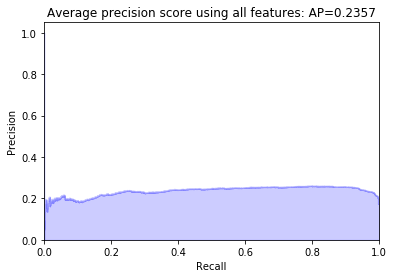

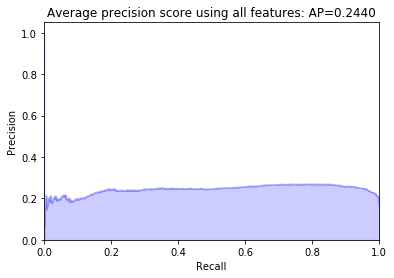

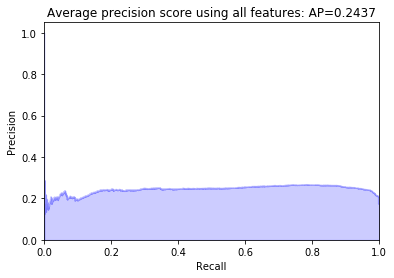

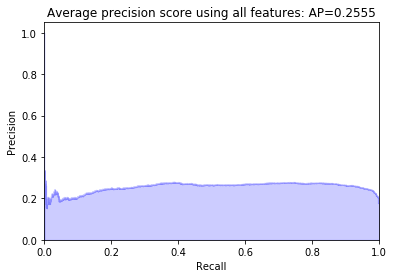

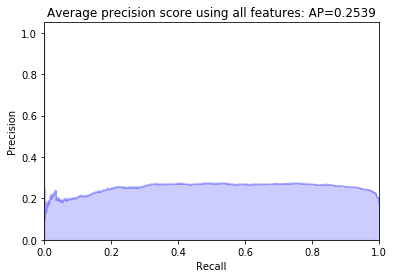

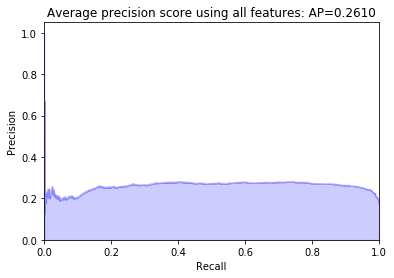

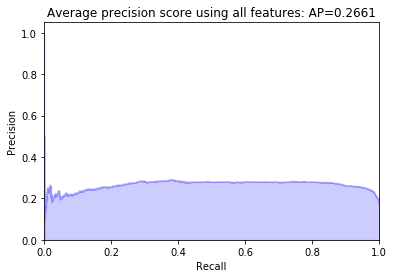

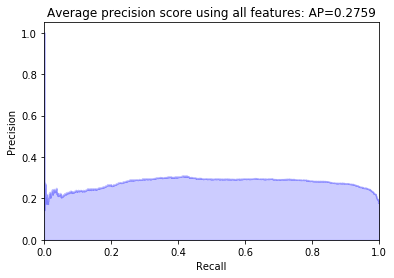

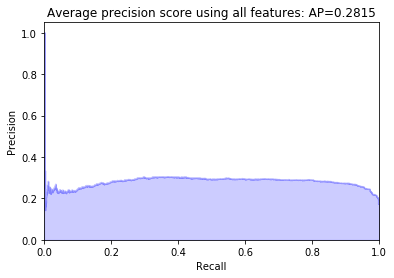

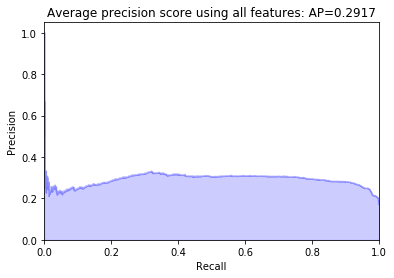

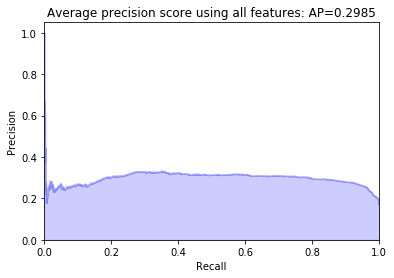

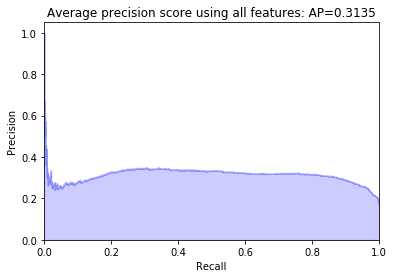

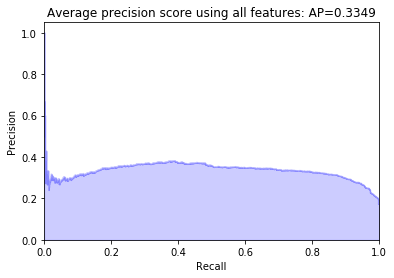

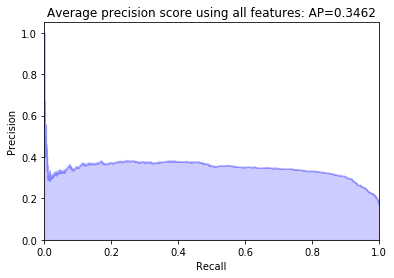

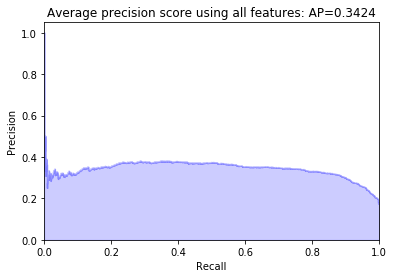

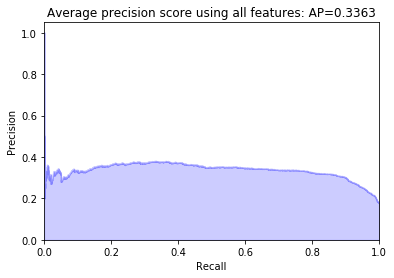

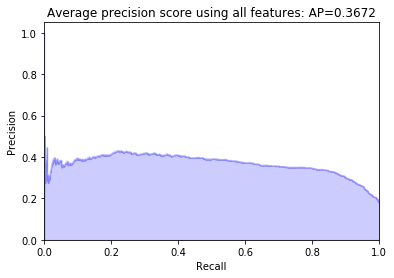

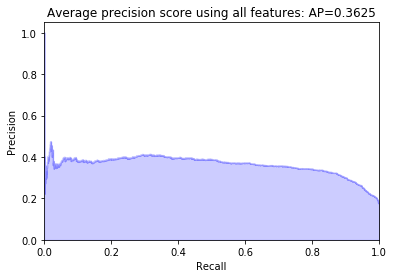

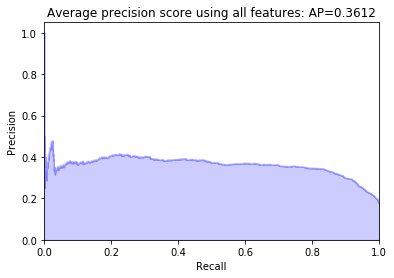

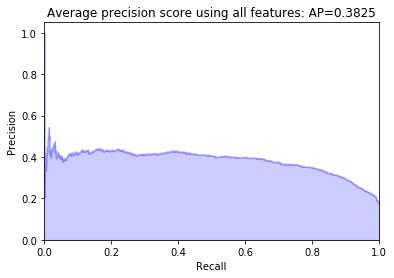

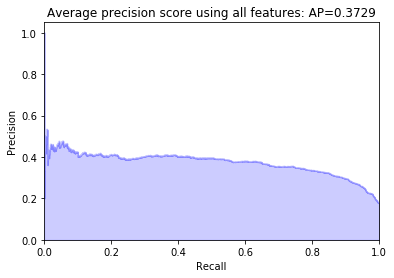

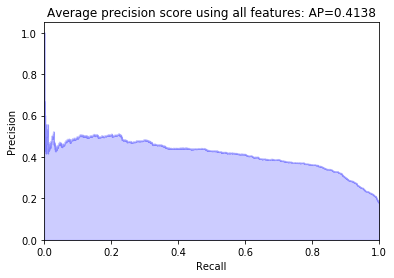

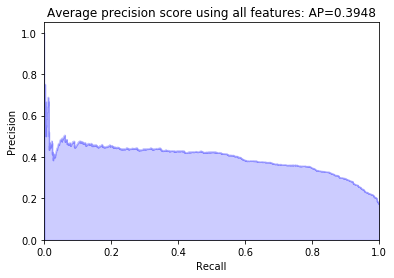

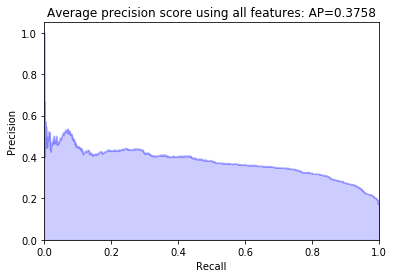

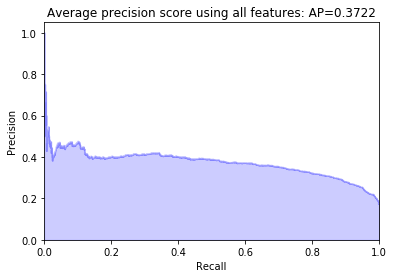

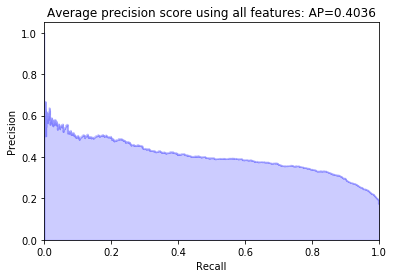

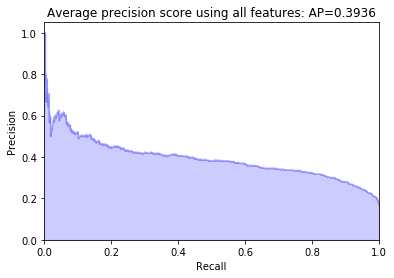

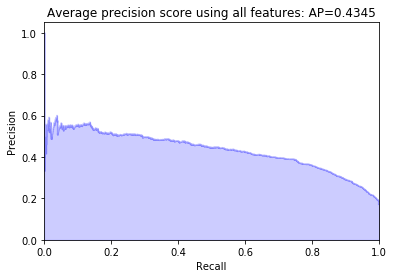

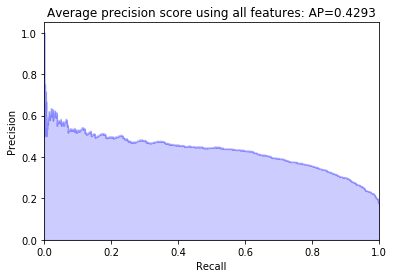

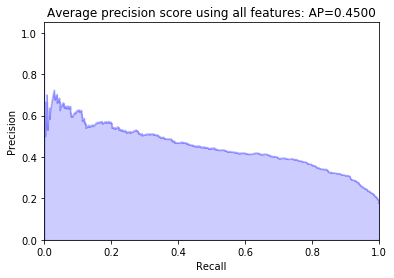

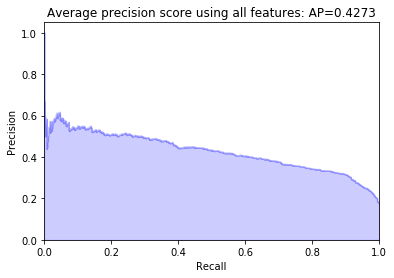

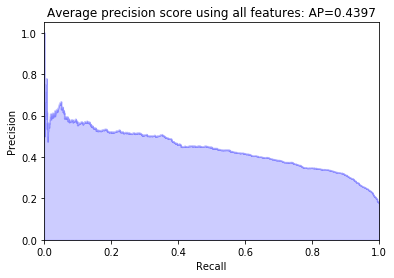

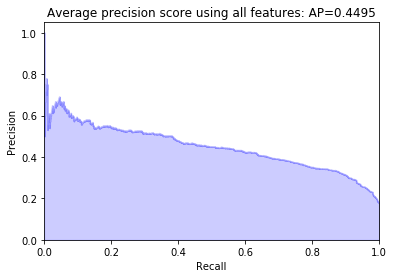

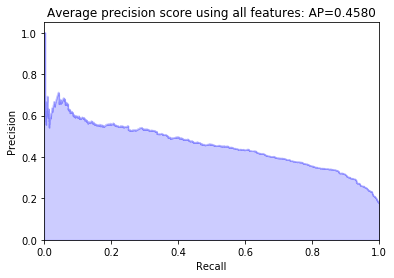

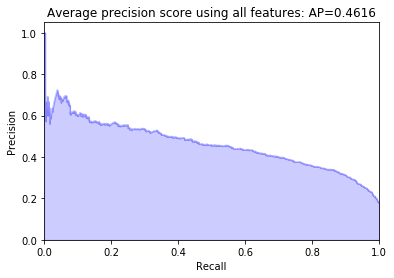

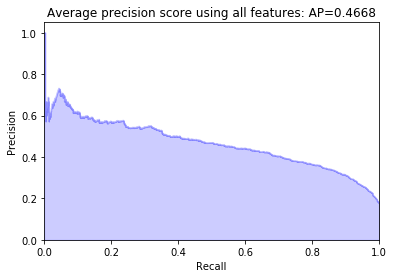

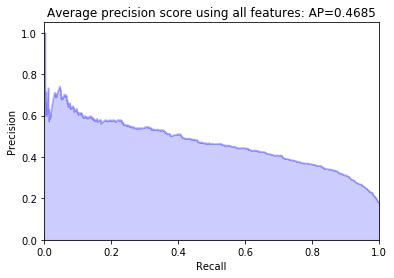

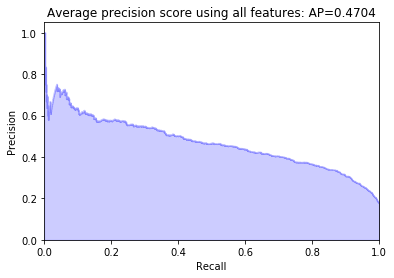

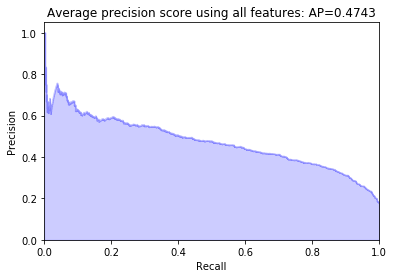

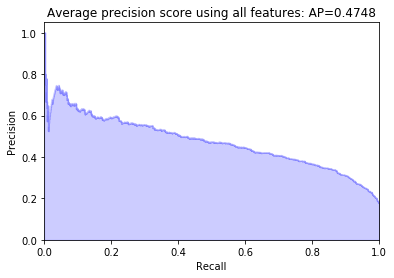

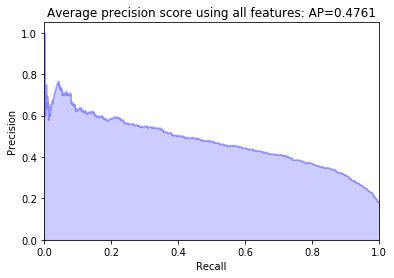

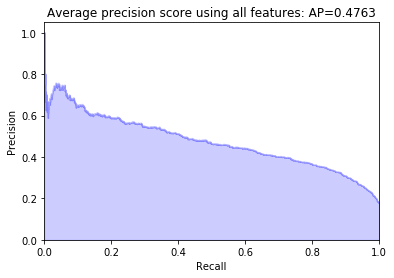

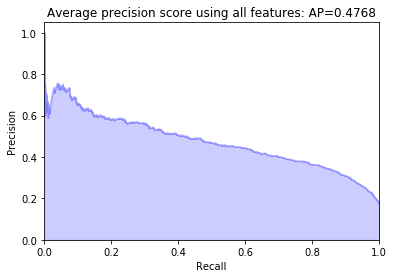

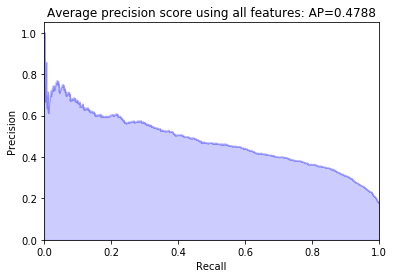

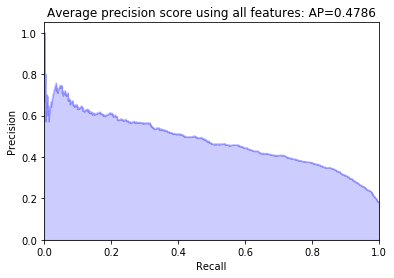

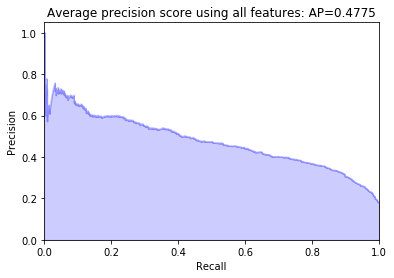

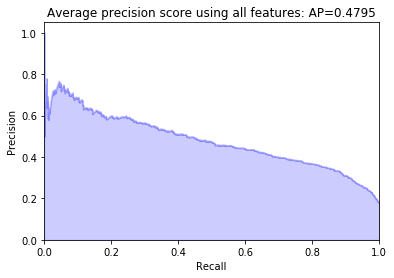

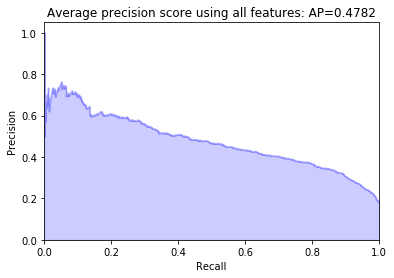

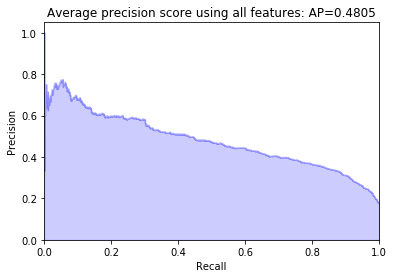

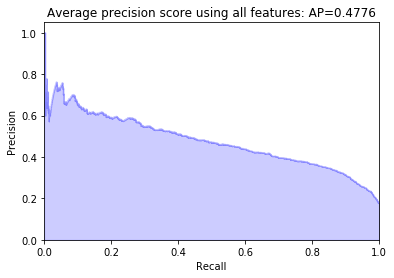

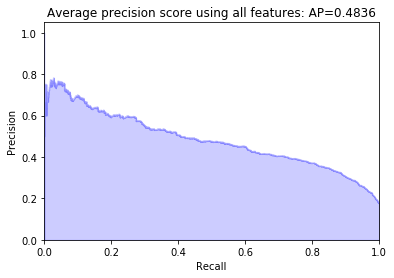

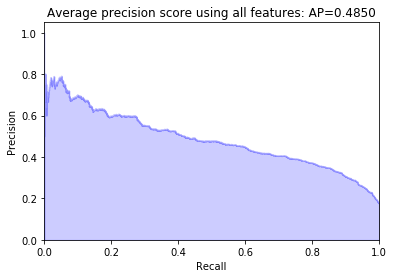

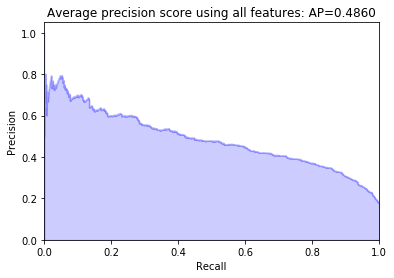

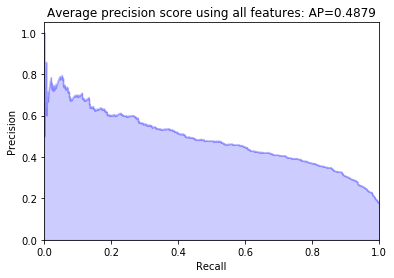

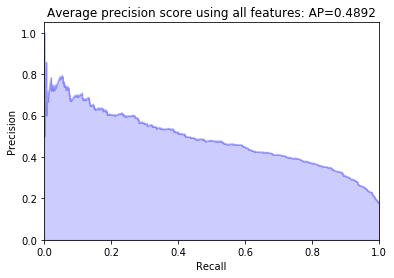

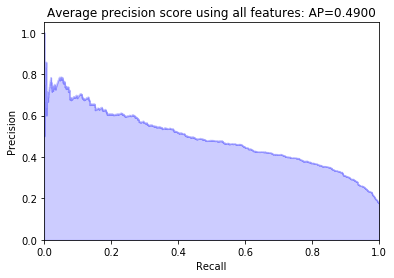

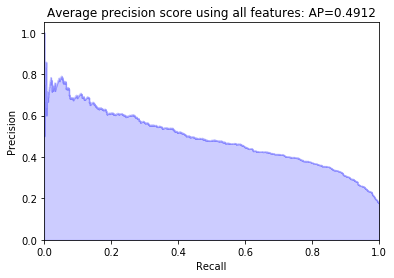

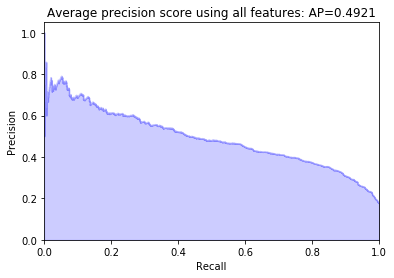

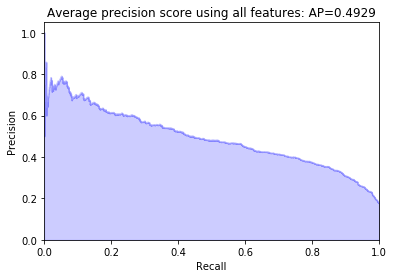

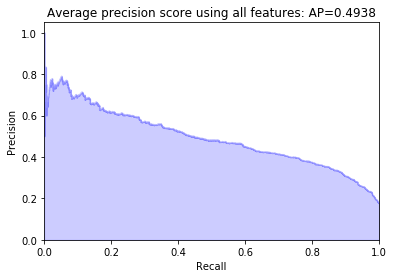

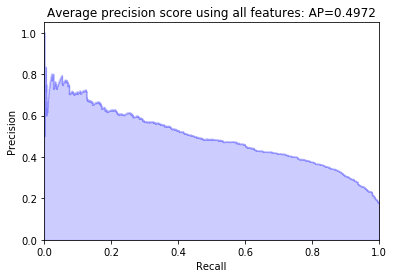

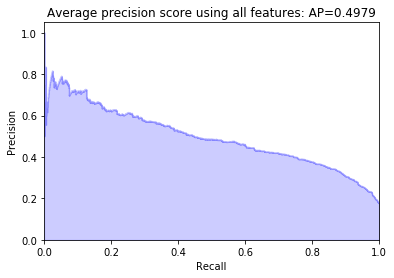

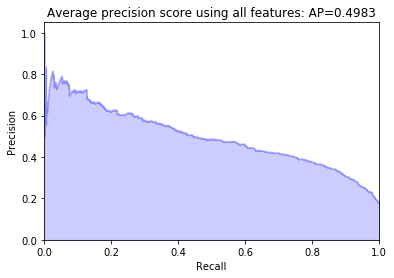

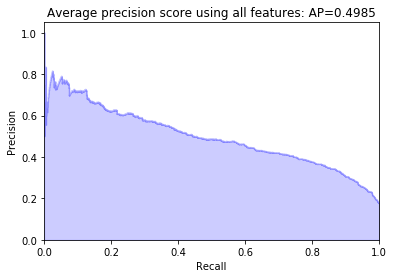

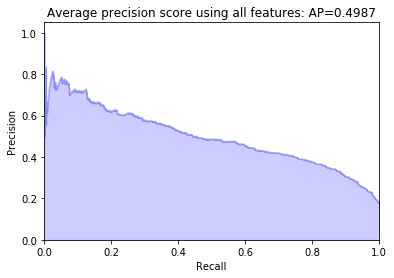

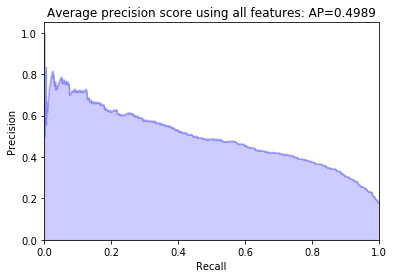

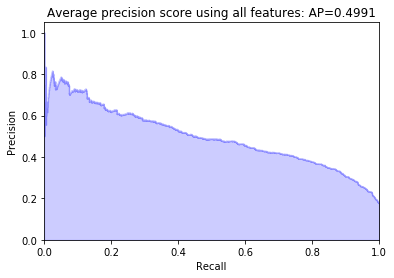

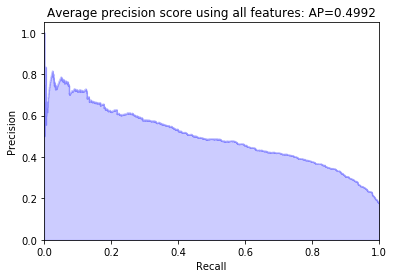

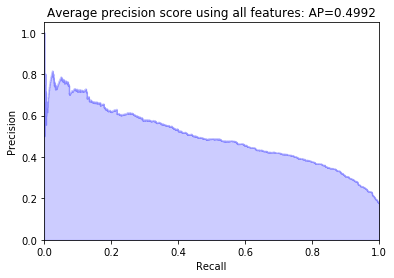

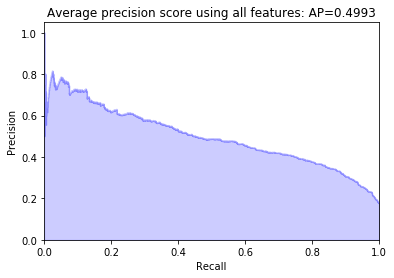

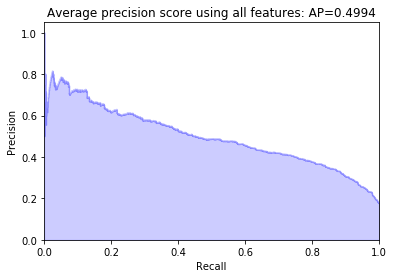

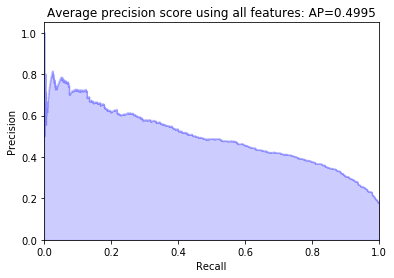

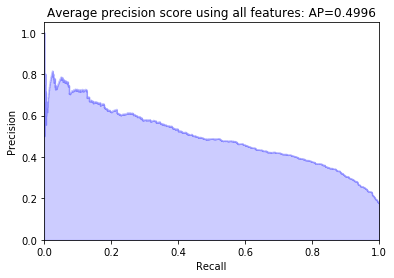

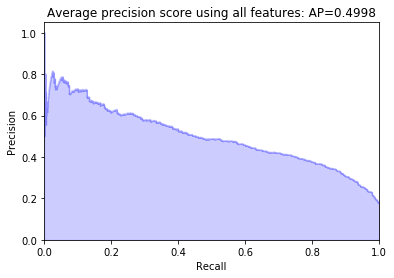

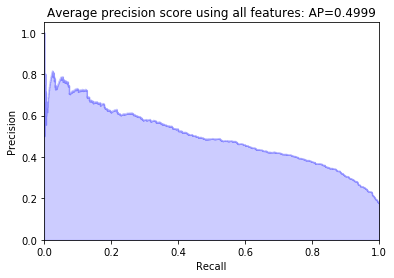

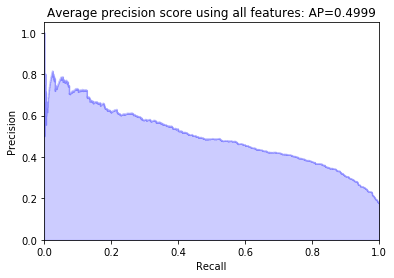

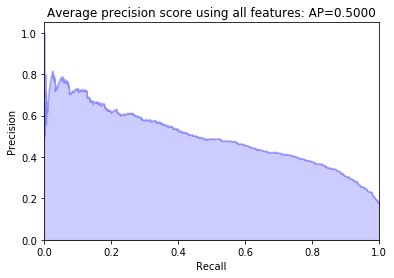

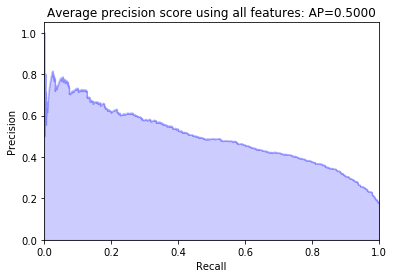

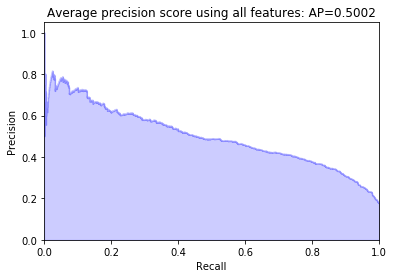

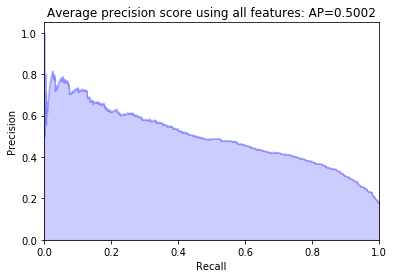

In [17]:
###########  Initialize all networks and their parameters  ##############
num_classes = 6

#lrs = [1e-1, 1e-2, 1e-3, 1e-4]
hidden_dims = [512]
lrs = [1e-5]
#hidden_dims = [128]
epochs = 80
best_models, all_val_losses, all_val_accs = [], [], []
preds, labels = [], []
pred_scores = []

for lr in lrs:
    for hidden_dim in hidden_dims:
        print '************** Parameters ********************'
        print 'lr: ' + str(lr) + ', hidden_dim: ' + str(hidden_dim)
        print 'Number of training examples: ' + str(len(train_events))
        print 'Number of validation examples: ' + str(len(val_events))
        
        hidden_dim_player=hidden_dim
        hidden_dim_player_coordinate=hidden_dim
        hidden_dim_frame=hidden_dim
        hidden_dim_event=hidden_dim
        
        player_feature_dim = 2048
        rgb_frame_feature_dim = 2048
        input_size_event = hidden_dim_frame + 2*hidden_dim_player + 2*hidden_dim_player_coordinate
        
        coordinate_linear_layer_1 = nn.Linear(2, hidden_dim_player_coordinate//2).cuda()
        coordinate_linear_layer_2 = nn.Linear(hidden_dim_player_coordinate, hidden_dim_player_coordinate//2).cuda()
        rgb_frame_lstm = simple_LSTM(input_size=rgb_frame_feature_dim, hidden_size=hidden_dim_frame, output_size=0).cuda()
        player_lstm = simple_LSTM(input_size=player_feature_dim, hidden_size=hidden_dim_player, output_size=0).cuda()
        coordinate_lstm = simple_LSTM(input_size=hidden_dim_player_coordinate, hidden_size=hidden_dim_player_coordinate, output_size=0).cuda()
        event_lstm = simple_LSTM(input_size=input_size_event, hidden_size=hidden_dim_event, output_size=6).cuda()
        linear_layer = nn.Linear(hidden_dim_player+hidden_dim_player_coordinate+hidden_dim_frame+hidden_dim_event, 1).cuda()
        softmax = nn.Softmax().cuda()
        
        best_player_lstm, best_coordinate_lstm, best_rgb_frame_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2, all_val_loss, all_val_acc, best_predictions, best_labels, pred_logits = train(train_events=train_events, val_events=val_events, num_classes=num_classes, num_epochs=epochs, print_every=5000,
              rgb_frame_lstm=rgb_frame_lstm, player_lstm=player_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm, 
              coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2, linear_layer=linear_layer, softmax=softmax, 
              lr_player=lr, lr_coordinate=lr, lr_rgb_frame=lr, lr_event=lr, 
              lr_coordinate_linear_layer_1=lr, lr_coordinate_linear_layer_2=lr, lr_linear_layer=lr, weight=[1, 1, 1, 0.1, 0.3, 1],
              hidden_dim_player=hidden_dim, hidden_dim_frame=hidden_dim, hidden_dim_coordinate=hidden_dim, hidden_dim_event=hidden_dim)
        
            
        best_models.append([best_rgb_frame_lstm, best_player_lstm, best_coordinate_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2])
        all_val_losses.append(all_val_loss)
        all_val_accs.append(all_val_acc)
        preds.append(best_predictions)
        labels.append(best_labels)
        pred_scores.append(pred_logits)

In [18]:
def get_ap(Y_test, y_score, n_classes, feature, save_name):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        #print Y_test[:, i]
        #print y_score[:, i]
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score using ' + feature + ' features: AP={0:0.4f}'
        .format(average_precision["micro"]))
    #plt.savefig('ap_new/' + save_name)
    return average_precision['micro']

(851, 6)
(851, 6)
0.500246231127


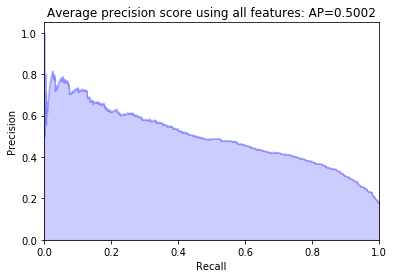

In [19]:
#print pred_scores
a = []
for i in pred_scores[0]:
    a += np.array(i.data)[0],
a = np.array(a)
print a.shape
b = []
for i in labels[0]:
    b += i[0],
b = np.array(b)
b_binary = label_binarize(b, [0, 1, 2, 3, 4, 5])
print b_binary.shape
print get_ap(b_binary, a, 6, 'all', 'all')

Normalized confusion matrix
[[ 0.04444444  0.02222222  0.02222222  0.6         0.28888889  0.02222222]
 [ 0.          0.19642857  0.          0.75        0.05357143  0.        ]
 [ 0.          0.          0.14285714  0.75714286  0.07142857  0.02857143]
 [ 0.02061856  0.0371134   0.04123711  0.74845361  0.10927835  0.04329897]
 [ 0.06040268  0.00671141  0.01342282  0.53691275  0.37583893  0.00671141]
 [ 0.04347826  0.          0.02173913  0.73913043  0.13043478  0.06521739]]


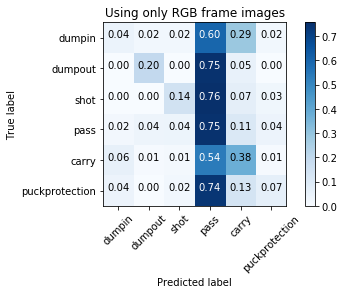

Validation accuracy: 52.64%


In [20]:
for i in range(len(preds)):

    cfm_frame = confusion_matrix(labels[i], preds[i])
    plt.figure()
    plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass', 'carry', 'puckprotection'], normalize=True,
                          title='Using only RGB frame images')
    plt.savefig('cfm/team_id&coordinates_1024_lessframes.png')
    plt.show()
    #acc_frame = float(np.sum(np.array(labels) == np.array(predictions))) / float(len(predictions))
    print 'Validation accuracy: ' + str('%.2f' % (max(all_val_accs[i])*100)) + '%'

In [21]:
print len(all_val_accs)
for i in range(len(all_val_accs)):
    print max(all_val_accs[i])

1
0.526439482961


In [22]:
print (len(best_model))

NameError: name 'best_model' is not defined

In [ ]:
hidden_dims = [128, 256]
for i, best_model in enumerate(best_models):

    rgb_frame_lstm = best_model[0]
    player_lstm = best_model[1]
    event_lstm = best_model[2]
    linear_layer = best_model[3]

    hidden_dim = hidden_dims[i]
    hidden_dim_player=hidden_dim
    hidden_dim_frame=hidden_dim
    hidden_dim_event=hidden_dim

    rgb_frame_lstm.eval()
    player_lstm.eval()
    event_lstm.eval()
    linear_layer.eval()
    val_loss, val_correct = 0, 0

    weight=[1, 1, 1, 0.1, 0.3, 1]
    weight = Variable(torch.FloatTensor(np.array(weight))).cuda()
    criterion = nn.MultiMarginLoss(p=2, weight=weight).cuda()

    labels, predictions = [], []
    for count_iter, event in enumerate(val_events):

        correct, loss, logits = step(event_line=event, criterion=criterion,
                             player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, event_lstm=event_lstm,
                             linear_layer=linear_layer, softmax=softmax,
                             hidden_dim_player=hidden_dim_player, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                             num_classes=num_classes)

        prediction = torch.max(logits, 1)[1].data
        event_name = event.split('_')[1]
        label = np.array([event_to_label[event_name]])
        predictions.append(prediction)
        labels.append(label)

        val_loss += loss.data[0]
        val_correct += correct
    print float(val_correct)/float(len(val_events))

    cfm_frame = confusion_matrix(labels, predictions)
    plt.figure()
    plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass', 'carry', 'puckprotection'], normalize=True,
                          title='Using only RGB frame images')
    #plt.savefig('cfm/rgb.png')
    plt.show()
    acc_frame = float(np.sum(np.array(labels) == np.array(predictions))) / float(len(predictions))
    print 'Validation accuracy: ' + str('%.2f' % (max(all_val_accs[i])*100)) + '%'

In [ ]:
# cfm_frame = confusion_matrix(labels, predictions)
# plt.figure()
# plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass'], normalize=True,
#                       title='Using only RGB frame images')
# plt.savefig('cfm/rgb.png')
# plt.show()
# acc_frame = float(np.sum(np.array(frame_labels) == np.array(frame_predictions))) / float(len(frame_predictions))
# print 'Accuracy for using only RGB frame images is: ' + str('%.2f' % (acc_frame*100)) + '%'